In [1]:
import os
import torch
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torchvision
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms 
from torchvision import models as m
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
import datetime
import gc  #garbage collector
from torchinfo import summary
from timm.models.vision_transformer import VisionTransformer
import json

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [4]:
torch.cuda.manual_seed(1412)
torch.cuda.manual_seed_all(1412)

In [5]:
#执行此代码时注意关闭VPN
IncV3 = m.inception_v3(pretrained=True) #resnet18_pretrained
#将导入的预训练模型中所有的参数锁住
for param in IncV3.parameters():
    param.requires_grad = False

In [6]:
num_ftrs = IncV3.fc.in_features  # 获取低级特征维度
IncV3.fc = nn.Linear(num_ftrs, 5)

In [7]:
model =IncV3.to(device)
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [8]:
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root)

    # 遍历文件夹，一个文件夹对应一个类别
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    # 排序，保证各平台顺序一致
    flower_class.sort()
    # 生成类别名称以及对应的数字索引
    class_indices = dict((k, v) for v, k in enumerate(flower_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 排序，保证各平台顺序一致
        images.sort()
        # 获取该类别对应的索引
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num)))
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))
    assert len(train_images_path) > 0, "number of training images must greater than 0."
    assert len(val_images_path) > 0, "number of validation images must greater than 0."
    
    plot_image = False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(flower_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(flower_class)), flower_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label

In [9]:
class MyDataSet():
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        # RGB为彩色图片，L为灰度图片
        if img.mode != 'RGB':
            raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [10]:
data_path = "/home/ubuntu/fy/外部验证/aptos_data/aptos_ori_gro"

In [11]:
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(data_path)

3662 images were found in the dataset.
2931 images for training.
731 images for validation.


In [12]:
img_size = 224
data_transform = {
        "train": transforms.Compose([
                                    transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
                          transforms.Resize(299),
                          transforms.CenterCrop(299),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])}

# 实例化训练数据集
train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                               transform=data_transform["train"]
                         )

# 实例化验证数据集
val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                           transform=data_transform["val"]
                       )



In [13]:
batch_size=32
batchdata = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               drop_last=True,
                                               collate_fn=train_dataset.collate_fn)


testdata = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                            drop_last=True,
                                             collate_fn=val_dataset.collate_fn)


dataloaders = {'train': batchdata , 'val': testdata }
dataset_sizes = {'train': len( batchdata), 'val': len(testdata)}

In [14]:
class EarlyStopping():
    def __init__(self, patience = 5, tol = 0.0005): #惯例地定义我们所需要的一切变量/属性\
        #当连续patience次迭代时，这一轮迭代的损失与历史最低损失之间的差值小于阈值时
        #就触发提前停止
        
        self.patience = patience
        self.tol = tol #tolerance，累积5次都低于tol才会触发停止
        self.counter = 0 #计数，计算现在已经累积了counter次
        self.lowest_loss = None
        self.early_stop = True #True - 提前停止，False - 不要提前停止
    
    def __call__(self,val_loss):
        if self.lowest_loss == None: #这是第一轮迭代
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter,self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
        return self.early_stop
        #这一轮迭代的损失与历史最低损失之间的差 - 阈值

In [15]:
def IterOnce(net, criterion, opt, x, y):
      """
    对模型进行一次迭代的函数
    
    net: 实例化后的架构
    criterion: 损失函数
    opt: 优化算法
    x: 这一个batch中所有的样本
    y: 这一个batch中所有样本的真实标签
    """
    outputs, _ = net(x)  # 假设模型输出是元组，_ 是辅助分类器的输出
    loss = criterion(outputs, y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True)
    yhat = torch.max(outputs, 1)[1]
    correct = torch.sum(yhat == y)
    return correct, loss

In [16]:
def TestOnce(net,criterion,x,y):
    """
    对一组数据进行测试并输出测试结果的函数
    
    net: 经过训练后的架构
    criterion：损失函数
    x：要测试的数据的所有样本
    y：要测试的数据的真实标签
    """
    #对测试，一定要阻止计算图追踪
    #这样可以节省很多内存，加速运算
    with torch.no_grad(): 
        sigma = net.forward(x)
        loss = criterion(sigma,y)
        yhat = torch.max(sigma,1)[1]
        correct = torch.sum(yhat == y)
    return correct,loss

In [17]:
def fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH):
    """
    对模型进行训练，并在每个epoch后输出训练集和测试集上的准确率/损失
    以实现对模型的监控
    实现模型的保存
    
    参数说明：
    net: 实例化后的网络
    batchdata：使用Dataloader分割后的训练数据
    testdata：使用Dataloader分割后的测试数据
    criterion：所使用的损失函数
    opt：所使用的优化算法
    epochs：一共要使用完整数据集epochs次
    tol：提前停止时测试集上loss下降的阈值，连续5次loss下降不超过tol就会触发提前停止
    modelname：现在正在运行的模型名称，用于保存权重时作为文件名
    PATH：将权重文件保存在path目录下
    
    """
    
    SamplePerEpoch = batchdata.dataset.__len__() #整个epoch里有多少个样本
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol=tol)
    highestacc = None
    
    for epoch in range(1,epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
             #non_blocking 非阻塞=True，表示允许多个线程同时占用一个资源
            #一般来说，一段代码/数据占用一部分计算资源时，该资源是不对其他代码/数据开放的
            #此时被占用的资源叫做临界资源，正在运行的代码/数据被叫做临界区
            #设置non_blocking=True，相当于允许多个代码在临界资源上运行
            #可以加速运算
            x = x.to(device,non_blocking=True)
            y = y.to(device,non_blocking=True).view(x.shape[0])
           
            correct, loss = IterOnce(net,criterion,opt,x,y)
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct
            
            if (batch_idx+1) % 125 == 0:
                #现在进行到了哪个epoch
                #现在训练到了多少个样本
                #总共要训练多少个样本
                #现在的训练的样本占总共需要训练的样本的百分比
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch
                                                       ,trainedsamples
                                                       ,allsamples
                                                       ,100*trainedsamples/allsamples))
            
        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train)/SamplePerEpoch #平均每个样本上的损失
        trainlosslist.append(TrainLossThisEpoch)
    
       #清理GPU内存
        del x,y,correct,loss,correct_train,loss_train
        gc.collect()
        torch.cuda.empty_cache()
      
    
        #每次训练完一个epoch，就在测试集上验证一下模型现在的效果
        net.eval()
        loss_test = 0
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x,y in testdata:
            x = x.to(device,non_blocking=True)
            y = y.to(device,non_blocking=True).view(x.shape[0])
           
            correct, loss = TestOnce(net,criterion,x,y)
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test )/TestSample
        testlosslist.append(TestLossThisEpoch)
        
        del x,y,correct,loss,correct_test, loss_test
        gc.collect()
        torch.cuda.empty_cache()
        
        #对每一个epoch，打印训练和测试的结果
        #训练集上的损失，测试集上的损失，训练集上的准确率，测试集上的准确率
        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch
                                                                                                  ,TestLossThisEpoch
                                                                                                  ,TrainAccThisEpoch
                                                                                                  ,TestAccThisEpoch))
        
        #如果测试集准确率出现新高/测试集loss出现新低，那我会保存现在的这一组权重
        if highestacc == None: #首次进行测试
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(),os.path.join(PATH,modelname+".pt"))
#             torch.save(net.state_dict(), os.path.join(PATH, str(modelname) + ".pt"))
            print("\t Weight Saved")
        
        #提前停止
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == "True":
            break
            
    print("Complete")
    return trainlosslist, testlosslist

In [18]:
def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,alpha=0.99,gamma=0,wd=0,tol=10**(-5)):
    
    torch.manual_seed(1412)
    
    #分割数据
    batchdata = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=bs,
                                               shuffle=True,
                                               pin_memory=True,
                                               drop_last=True,
                                               collate_fn=train_dataset.collate_fn)

    testdata =torch.utils.data.DataLoader(val_dataset,
                                             batch_size=bs,
                                             drop_last=True,
                                             shuffle=False,
                                             pin_memory=True,
                                             
                                             collate_fn=val_dataset.collate_fn)
    
    #损失函数，优化算法
    criterion = nn.CrossEntropyLoss(reduction="sum") #进行损失函数计算时，最后输出结果的计算模式
    opt = optim.RMSprop(net.parameters(),lr=lr
                        ,alpha=alpha,momentum=gamma,weight_decay=wd)
    
    #训练与测试
    trainloss, testloss = fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH)
    
    return trainloss, testloss

In [19]:
#绘图函数
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="Trainloss")
    plt.plot(testloss, color="orange", label="Testloss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

inceptionv3_1
	 Train Loss:0.755751, Test Loss:0.537303, Train Acc:72.637%, Test Acc:66.211%
	 Train Loss:0.513601, Test Loss:0.458112, Train Acc:76.561%, Test Acc:69.904%
	 Weight Saved
	 Train Loss:0.530244, Test Loss:0.419031, Train Acc:76.186%, Test Acc:71.956%
	 Weight Saved
	 Train Loss:0.511578, Test Loss:0.414642, Train Acc:76.117%, Test Acc:71.819%
	 Train Loss:0.498945, Test Loss:0.409882, Train Acc:76.834%, Test Acc:73.735%
	 Weight Saved
	 Train Loss:0.507061, Test Loss:0.456881, Train Acc:76.527%, Test Acc:69.220%
	 NOTICE: Early stopping counter 1 of 5
	 Train Loss:0.528506, Test Loss:0.402412, Train Acc:75.810%, Test Acc:73.598%
	 Train Loss:0.519780, Test Loss:0.404614, Train Acc:76.424%, Test Acc:72.503%
	 NOTICE: Early stopping counter 1 of 5
	 Train Loss:0.513413, Test Loss:0.433662, Train Acc:76.322%, Test Acc:73.461%
	 NOTICE: Early stopping counter 2 of 5
	 Train Loss:0.497236, Test Loss:0.438811, Train Acc:77.346%, Test Acc:72.093%
	 NOTICE: Early stopping counte

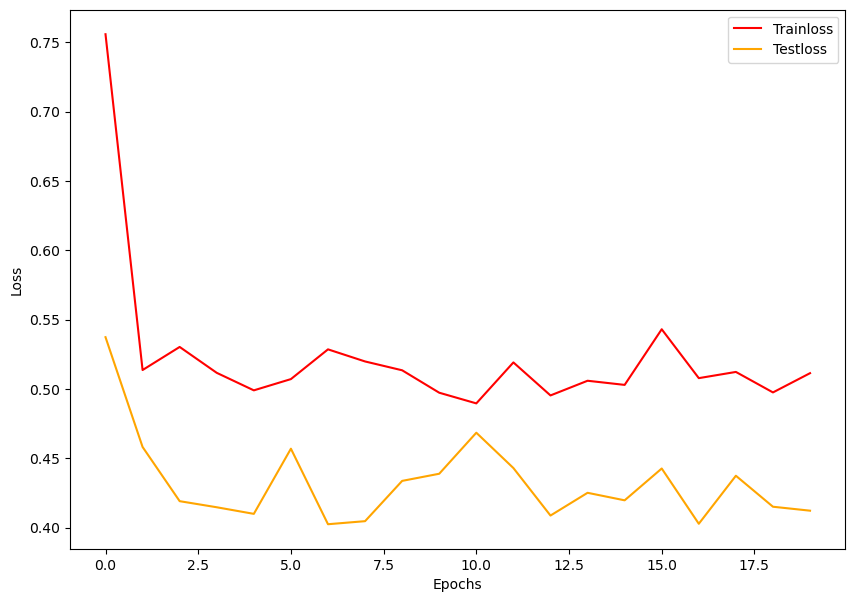

In [25]:
modelname = "inceptionv3_1"
torch.manual_seed(420)
PATH  ="/home/ubuntu/fy/外部验证/feature selection"
# model2.load_state_dict(torch.load("/home/ubuntu/jupyter notebook/MyNet2_0.001_1.pt"))
print(modelname)
net = model.to(device,non_blocking=True)
trainloss, testloss = full_procedure(net ,epochs=20, bs=128#令batch_size下降一半
                                     ,modelname=modelname
                                     ,PATH = PATH
                                     ,lr = 0.001
                                     ,alpha=0.99
                                     ,gamma= 0.001
                                     ,wd = 0
                                     ,tol = 10**(-5)
                                     ) #wd非常敏感，因此要小心地进行调整
plotloss(trainloss,testloss)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, cohen_kappa_score
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

model.load_state_dict(torch.load("/home/ubuntu/fy/外部验证/feature selection/inceptionv3_1.pt"))

def evaluate_model(model, dataloader, device):
    model.eval()   # 设置模型为评估模式
    true_labels = []
    pred_labels = []
    # 遍历数据
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        
    return true_labels, pred_labels

# 获取预测和真实标签
true_labels, pred_labels = evaluate_model(model, dataloaders['val'], device)

# Convert to numpy arrays
predicted_classes = np.array(pred_labels )
true_labels = np.array(true_labels)

# Calculate evaluation metrics
confusion = confusion_matrix(true_labels, predicted_classes)
accuracy = accuracy_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes, average='weighted')
precision = precision_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

# Calculate Quadratic Weighted Kappa
kappa = cohen_kappa_score(true_labels, predicted_classes, weights='quadratic')

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Quadratic Weighted Kappa:", kappa)


Confusion Matrix:
[[347   1  13   0   0]
 [  4   9  60   0   1]
 [  9   5 183   1   1]
 [  1   0  34   2   1]
 [  0   0  28   1   3]]
Accuracy: 0.7727272727272727
Recall: 0.7727272727272727
Precision: 0.7683506646655232
F1 Score: 0.7265853898668874
Quadratic Weighted Kappa: 0.8119444381294474


AttributeError: 'InceptionOutputs' object has no attribute 'numpy'

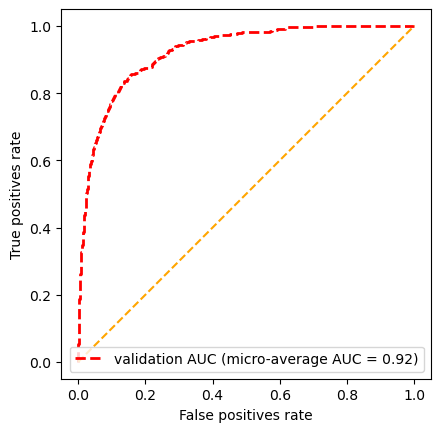

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import pandas as pd
import math

def plot_roc_micro(name, labels, predictions, class_names, **kwargs):
    # Compute micro-average ROC curve and ROC AUC score
    fpr, tpr, _ = metrics.roc_curve(pd.get_dummies(labels).values.ravel(), predictions.ravel())
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the micro-average ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=name+' (micro-average AUC = {0:.2f})'.format(roc_auc), linewidth=2, **kwargs)
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    plt.legend(loc='lower right')
    ax = plt.gca()
    ax.set_aspect('equal')

# Assuming you have defined `class_names` as a list of four class names
class_names = ['Class_1', 'Class_2', 'Class_3', 'Class_4','class_5']

val_pre_auc = []
val_label_auc = []

train_ds = dataloaders['train']
val_ds = dataloaders['val']

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_ds:
        images = images.to(device)
        labels = labels.to(device)
        predictions_auc = model(images)
        val_pre_auc.append(predictions_auc.cpu().numpy())  # Output probabilities for all classes
        val_label_auc.append(labels.cpu().numpy())

val_pre_auc = np.vstack(val_pre_auc)
val_label_auc = np.hstack(val_label_auc)

plot_roc_micro('validation AUC', val_label_auc, val_pre_auc, class_names, color="red", linestyle='--')

# Compute the ROC AUC score for the validation set
auc_score_val = metrics.roc_auc_score(pd.get_dummies(val_label_auc), val_pre_auc, multi_class='ovr')

train_pre_auc = []
train_label_auc = []

model.train()  # Set the model back to training mode
with torch.no_grad():
    for images, labels in train_ds:
        images = images.to(device)
        labels = labels.to(device)
        predictions_auc = model(images)
#         train_pre_auc.append(predictions_auc.cpu().numpy())
        train_pre_auc.append(predictions_auc.numpy())
        train_label_auc.append(labels.cpu().numpy())

train_pre_auc = np.vstack(train_pre_auc)
train_label_auc = np.hstack(train_label_auc)

plot_roc_micro('training AUC', train_label_auc, train_pre_auc, class_names, color="blue", linestyle='--')

# Compute the ROC AUC score for the training set
auc_score_train = metrics.roc_auc_score(pd.get_dummies(train_label_auc), train_pre_auc, multi_class='ovr')

plt.legend(loc='lower right')
plt.show()

print("训练集的AUC值为：", auc_score_train, "验证集的AUC值为：", auc_score_val)
